In [ ]:
!nvidia-smi

In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

from sklearn.metrics import f1_score

import time
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
from googletrans import Translator
from deep_translator import GoogleTranslator
import random

#nltk.download('wordnet')
#nltk.download('omw-1.4')

translator = Translator()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
#df_data = pd.read_csv('multi_label_binarizer_MEISD.csv')

In [3]:
df_data = pd.read_csv('balanced_augmented_data.csv')

In [4]:
df_data.head()

,Utterances,label
0,had you asked a couple of weeks ago,2
1,young benjamin here knows what's coming,2
2,i don't see why they had to keep my credit car...,2
3,Jaime's away on a sensitive diplomatic mission.,2
4,"hell, yeah",2


In [6]:
# # For the multilabel classification we use:
# columns = ['Utterances', 'sentiment_0', 'sentiment_1', 'sentiment_2']
# multi_columns = df_data[columns].copy()

In [7]:
# multi_columns

In [8]:
# df_data['label'] = multi_columns[['sentiment_0', 'sentiment_1', 'sentiment_2']].idxmax(axis=1)
# df_data['label'] = df_data['label'].apply(lambda x: int(x.split('_')[1]))
# df_data = df_data[['Utterances', 'label']]
# df_data

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [11]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  1284,  1132,  5193,   139,  9637,  1942, 22559, 17260,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [12]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [13]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [14]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [15]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [16]:
token_lens = []

for txt in df_data['Utterances']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

C:\Users\Julix\AppData\Local\Temp\ipykernel_21092\453859461.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

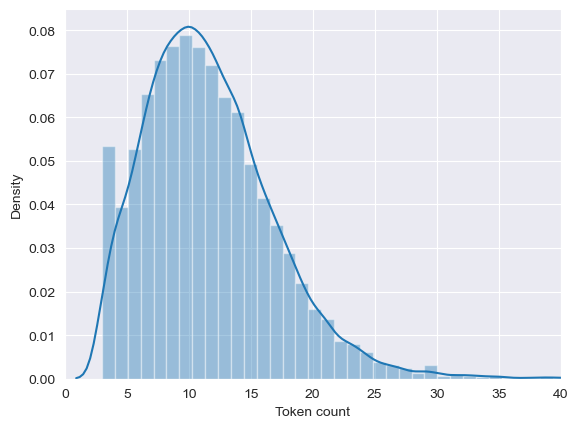

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 40])
plt.xlabel('Token count')

In [18]:
# Hyperparameters
MAX_LEN = 30 #50 #128  # wiekszosc tokenow zdaje sie byc ponizej 40, klasycznie wklada sie tu 256, my przystaniemy na 30
TRAIN_BATCH_SIZE = 8 #8 #16 #32 
#Czasami, przy bardzo niskim tempie uczenia i zbyt dużych batchach, model może wolniej konwergować. Spróbuj zmniejszyć wielkość batcha, np. z 16 do 8.
VALID_BATCH_SIZE = 8 #8 #16 #32
TEST_BATCH_SIZE = 8 #8 #16 #32
EPOCHS = 10
LEARNING_RATE = 0.001 #1e-05
# Ustawienie bardzo niskiego współczynnika uczenia (np. 1e-05) może spowodować, że model uczy się bardzo wolno, co prowadzi do sytuacji, w której po wielu epokach nie ma znaczącej poprawy w wynikach walidacji.

THRESHOLD = 0.2 # threshold for the sigmoid


In [19]:
# Data Augmentation

# 1. Synonym Replacement
def synonym_replacement(text):
    words = text.split()
    new_words = words[:]
    num_replacements = max(1, len(words) // 5)  # Replace about 20% of words
    random_words = random.sample(words, num_replacements)

    for word in random_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            #synonym = synonyms[0].lemmas()[0].name()  # Take first synonym
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:  # Avoid replacement if the synonym is identical
                new_words = [synonym if w == word else w for w in new_words]
    return ' '.join(new_words)


# 2. Random Insertion
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        new_word = random.choice(words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, new_word)
    return ' '.join(words)


# 3. Random Deletion
def random_deletion(text, p=0.3):
    words = text.split()
    if len(words) == 1:
        return text  # Avoid deleting single-word text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if not new_words:
        return random.choice(words)  # Return one word if all words are deleted
    return ' '.join(new_words)

# 4. Back Translation
def back_translation(text, src_lang='en', mid_lang='fr', max_retries=3):
    attempt = 0
    while attempt < max_retries:
        try:
            translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
            back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
            return back_translated
        except Exception as e:
            print(f"Back translation error on attempt {attempt + 1}: {e}")
            attempt += 1
            time.sleep(1)
    raise ValueError("Back translation failed")

In [20]:
def augment_text(text, num_augments=2):
    augmented_texts = []
    for _ in range(num_augments):
        augmentation_choice = random.choice(['synonym', 'insertion', 'deletion', 'back_translation'])
        if augmentation_choice == 'synonym':
            augmented_texts.append(synonym_replacement(text))
        elif augmentation_choice == 'insertion':
            augmented_texts.append(random_insertion(text))
        elif augmentation_choice == 'deletion':
            augmented_texts.append(random_deletion(text))
        elif augmentation_choice == 'back_translation':
            augmented_texts.append(back_translation(text))
    return augmented_texts

In [21]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [22]:
# class_counts = df_train['label'].value_counts()
# max_count = class_counts.max()
# 
# augmented_data = {'Utterances': [], 'label': []}
# 
# for label in class_counts.index:
#     class_subset = df_train[df_train['label'] == label]
#     augmented_data['Utterances'].extend(class_subset['Utterances'])
#     augmented_data['label'].extend(class_subset['label'])
# 
#     num_to_augment = max_count - len(class_subset)
#     for _, row in tqdm(class_subset.iterrows(), total=num_to_augment, desc=f"Augmenting class {label}"):
#         if num_to_augment <= 0:
#             break
#         new_texts = augment_text(row['Utterances'], num_augments=2)
#         for new_text in new_texts:
#             if num_to_augment <= 0:
#                 break
#             augmented_data['Utterances'].append(new_text)
#             augmented_data['label'].append(label)
#             num_to_augment -= 1

In [23]:
# augmented_df = pd.DataFrame(augmented_data)
# 
# augmented_df.to_csv('balanced_augmented_data.csv', index=False)
# print("Augmented data saved to 'balanced_augmented_data.csv'")

In [24]:
# augmented_data = {'Utterances': [], 'label': []}
# 
# for index, row in tqdm(df_train.iterrows(), total=len(df_train), desc="Augmenting data"):
#     original_text = row['Utterances']
#     sentiment_labels = row[['label']].tolist()
#     #emotion_labels = row[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8', 'emotion_9']].tolist()
#     #intensity_labels = row[['intensity_1', 'intensity_2', 'intensity_3']].tolist()
# 
#     augmented_data['Utterances'].append(original_text)
#     augmented_data['label'].append(sentiment_labels)
#     #augmented_data['Emotion_Labels'].append(emotion_labels)
#     #augmented_data['Intensity_Labels'].append(intensity_labels)
# 
#     new_texts = augment_text(original_text, num_augments=2)
#     for new_text in new_texts:
#         augmented_data['Utterances'].append(new_text)
#         augmented_data['label'].append(sentiment_labels)  # Kopiuj etykiety do nowych przykładów
#         #augmented_data['Emotion_Labels'].append(emotion_labels)
#         #augmented_data['Intensity_Labels'].append(intensity_labels)
# 
# augmented_df = pd.DataFrame(augmented_data)
# #augmented_df.to_csv('augmented_data.csv', index=False)
# #print("Augmented data saved to 'augmented_data.csv'")

In [25]:
# augmented_df.to_csv('augmented_data.csv', index=False)
# print("Augmented data saved to 'augmented_data.csv'")

In [26]:
print(f"Original train size: {df_train.shape}")
#print(f"Augmented train size: {augmented_df.shape}")

# df_train = augmented_df

print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

Original train size: (17139, 2)
Validation size: (3673, 2), Test size: (3673, 2)


In [27]:
label_frequencies = df_train['label'].value_counts()
label_frequencies_percent = df_train['label'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)


label
2    34.074333
1    34.039326
0    31.886341
Name: proportion, dtype: float64
label
2    5840
1    5834
0    5465
Name: count, dtype: int64


In [28]:
#columns = multi_columns.columns
#categor_freq = multi_columns[columns[1:]].sum() / multi_columns.shape[0]
#categor_freq

In [29]:
#class_distribution = multi_columns[['sentiment_0', 'sentiment_1', 'sentiment_2']].sum()
#print(class_distribution)

In [30]:
class_distribution = df_train['label'].value_counts(normalize=True)
print(class_distribution)

label
2    0.340743
1    0.340393
0    0.318863
Name: proportion, dtype: float64


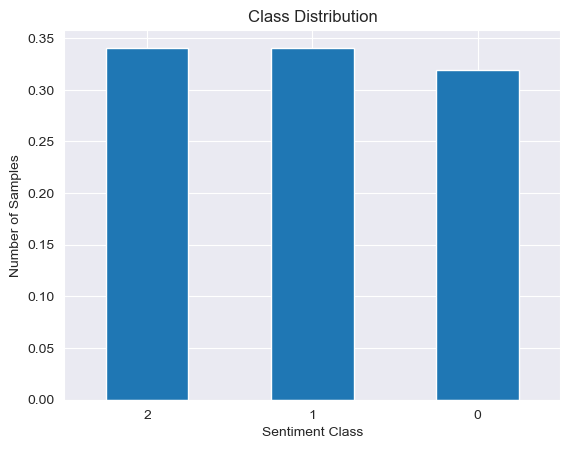

In [31]:
import matplotlib.pyplot as plt

# Wykres rozkładu klas
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [32]:
# import matplotlib.pyplot as plt
# 
# plt.rcParams["figure.figsize"] = (15, 3)
# plt.bar(categor_freq.index, categor_freq.values)
# _ = plt.xticks(rotation=45)

In [33]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (17139, 2), Test: (3673, 2), Valid: (3673, 2)


In [34]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        # Upewnij się, że etykiety są typu całkowitego (int)
        self.targets = self.df['label'].astype(int).values 
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])  # 'index' jest prawidłowe
        #utterances = " ".join(utterances.split())  # Usuwa niepotrzebne białe znaki

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)  # Zapewnij typ long
        # print(f"Target dtype: {target.dtype}")  # Debugging

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long),  # Zapewnij typ long
            'utterances': utterances
        }


In [35]:
target_list = list(df_data.columns)
target_list = target_list[1:]
target_list

['label']

In [36]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [37]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0
                                                )

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=VALID_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0
                                              )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0
                                               )

In [38]:
data = next(iter(train_data_loader))

In [39]:
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'targets', 'utterances'])
torch.Size([8, 30])
torch.Size([8, 30])
torch.Size([8])


In [40]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)

In [41]:
bert_model.config.hidden_size

768

In [42]:
class BERTSentimentClass(torch.nn.Module):
    def __init__(self):
        super(BERTSentimentClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)
        self.dropout = torch.nn.Dropout(p=0.3) #0.5
        self.linear = torch.nn.Linear(bert_model.config.hidden_size, 3)
        #self.softmax = nn.Softmax(dim=1) #remove for sentiment analysis
        #CrossEntropyLoss automatycznie aplikuje funkcję softmax, więc nie ma potrzeby używać Softmax w modelu.


    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        #pooler_output = self.pooler_output
        dropout_output = self.dropout(output.pooler_output)
        linear_output = self.linear(dropout_output)
        #output = self.dropout(linear_output)
        # output = self.softmax(linear_output)
        return linear_output

model = BERTSentimentClass()

# # Freezing BERT layers:
#for name, param in model.bert_model.named_parameters():
#    if "encoder.layer.10" in name or "encoder.layer.11" in name:
#        param.requires_grad = True
#    else:
#        param.requires_grad = False

model.to(device)


BERTSentimentClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [43]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 30])
torch.Size([8, 30])


In [44]:
#class_distribution = multi_columns[['sentiment_0', 'sentiment_1', 'sentiment_2']].sum()
#total_samples = sum(class_distribution)
#class_weights = [total_samples / count for count in class_distribution]
#class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#class_weights

In [45]:
class_distribution = df_train['label'].value_counts(normalize=True)
total_samples = sum(class_distribution)
class_weights = [total_samples / count for count in class_distribution]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([2.9348, 2.9378, 3.1361])

In [46]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)
#change for sentiment analysis

In [47]:
# TensorBoard writer
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs')

# Harmonogram zmiany learning rate
from torch.optim.lr_scheduler import StepLR

In [48]:
from transformers import AdamW, get_linear_schedule_with_warmup
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
# Learning Rate Tuning
#total_steps = len(train_data_loader) * EPOCHS
#scheduler = get_linear_schedule_with_warmup(
#    optimizer,
#    num_warmup_steps=0,
#    num_training_steps=total_steps
#)
#loss_fn = nn.CrossEntropyLoss().to(device)

D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Regularization (Dodanie Weight Decay)
Weight decay to inaczej L2 regularizacja, która zapobiega nadmiernemu dopasowaniu (overfittingowi). W Adam możesz dodać weight decay w następujący sposób:

Dodanie Weight Decay do Optimizera: Ustaw wartość weight decay w optymalizatorze. Standardowe wartości mieszczą się w zakresie 1e-4 do 1e-5:

python code
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
Analiza Wyników: Weight decay zmniejsza wielkość wag w czasie, co stabilizuje uczenie. Po dodaniu weight decay zwróć uwagę na to, czy train_loss i val_loss są bliżej siebie – powinny się zbliżyć, co jest oznaką redukcji overfittingu.

Aby zwiększyć regularizację, możesz zastosować tzw. weight decay, czyli L2 regularizację, podczas tworzenia optymalizatora. weight decay dodaje karę (regularizację) na wagi modelu, co może pomóc w ograniczeniu przeuczenia (overfitting). Możesz kontrolować siłę regularizacji za pomocą wartości weight_decay przy tworzeniu optymalizatora, takiego jak Adam.

Jak ustawić weight decay w optymalizatorze?
Podczas inicjalizacji optymalizatora, dodaj parametr weight_decay i przypisz mu wartość, która określi siłę regularizacji. Przykładowo, weight_decay=0.01 to dobry punkt wyjścia, ale możesz testować różne wartości, takie jak 0.001, 0.01, czy 0.1, aby znaleźć optymalną dla Twojego modelu.

# Inicjalizacja optymalizatora Adam z regularizacją L2
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
Rola weight_decay
Wartość weight_decay=0.01 oznacza umiarkowaną regularizację.
Wyższe wartości, np. weight_decay=0.1, zwiększają regularizację, co może zmniejszyć przeuczenie, ale też obniżyć dokładność na zbiorze treningowym.
Niższe wartości, np. weight_decay=0.001 lub niższe, mają mniejszy wpływ na regularizację, ale mogą pomóc, jeśli model już ma dobrą dokładność na zbiorze walidacyjnym.

Wybór Najlepszej Wartości
Wybierz wartość weight_decay, która daje najlepszą równowagę między niskim val_loss a wysoką val_acc. Pamiętaj, że wyższe wartości weight_decay zwiększają regularizację, co może zmniejszyć overfitting, ale też potencjalnie obniżyć zdolność modelu do dopasowania się do danych.

Zależność między learning rate a weight_decay
Wyższe wartości weight_decay (np. 1e-2) wymagają zazwyczaj niższego learning rate, ponieważ większa regularizacja silniej wpływa na wagę parametrów, co stabilizuje model i zapobiega overfittingowi.
Z kolei niższe wartości weight_decay (np. 1e-5 lub 1e-6) pozwalają na większą swobodę dopasowania modelu do danych i mogą lepiej działać przy nieco wyższym learning rate (np. 2e-5 lub 3e-5).


7. Dalsze Kroki
Layer-Wise Learning Rate: Możesz również eksperymentować z różnymi learning rates dla różnych warstw, co może jeszcze bardziej poprawić wyniki.
Early Stopping: Dodaj mechanizm wczesnego zatrzymania treningu, aby uniknąć nadmiernego trenowania modelu.
Eksperymenty z Hiperparametrami: Możesz rozważyć korzystanie z narzędzi do automatycznego tuningu hiperparametrów, takich jak Optuna czy Ray Tune, aby systematycznie znaleźć optymalne wartości.


## Learning Rate Tuning

Adaptacyjna redukcja learning rate za pomocą torch.optim.lr_scheduler.ReduceLROnPlateau pozwala obniżyć learning rate, kiedy model przestaje poprawiać wyniki. Możemy to zrobić w ten sposób:

Inicjalizacja Optimizera i Schedulera": przy optymalizatorze AdamW (lub innego). Po zdefiniowaniu optymalizatora dodaj ReduceLROnPlateau:

python code

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Początkowy learning rate
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Początkowy learning rate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
    mode='min': Zmniejsza learning rate, gdy minimalizowana jest wartość (np. val_loss).
    patience=2: Liczba epok bez poprawy przed obniżeniem learning rate.
    factor=0.5: Po jakim czynniku obniżyć learning rate (np. z 1e-3 na 5e-4).
    verbose=True: Informuje w logach o zmianie learning rate.

Wykorzystanie Schedulera podczas trenowania: Po zakończeniu każdej epoki przekaż do schedulera wynik val_loss, by sprawdzić, czy learning rate wymaga obniżenia:

python code
        scheduler.step(val_loss)
Użycie scheduler.step(val_loss) automatycznie sprawi, że learning rate zostanie zmniejszony w miarę potrzeby.



In [49]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(ids, mask, token_type_ids)

        # Calculate loss
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        # Collect predictions and labels for F1-score
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        loop.set_postfix(batch_loss=loss.item())

    # Calculate F1-score for training data
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return model, correct_predictions / num_samples, np.mean(losses), train_f1


In [50]:
def eval_model(validation_loader, model, epoch):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(ids, mask, token_type_ids)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Calculate predictions and accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Logowanie do TensorBoard
    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1

In [51]:
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import io

history = defaultdict(list)
best_accuracy = 0
writer = SummaryWriter(log_dir='logs')

def plot_confusion_matrix(cm, class_names, epoch):
    figure = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix at Epoch {epoch}')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = torch.tensor(np.frombuffer(buf.getvalue(), dtype=np.uint8)).float()
    writer.add_image('Confusion Matrix', image, epoch)

    plt.close(figure)  


In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
best_f1 = 0
patience = 3  # Ile epok czekasz na poprawę
patience_counter = 0


In [52]:
# Główna pętla treningowa
# %%time
history = defaultdict(list)
best_f1 = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss, train_f1 = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(val_data_loader, model, epoch)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')

    # Logowanie metryk do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('F1-Score/train', train_f1, epoch)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # Sprawdzenie najlepszej F1 i zapisanie modelu
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_f1 = val_f1
        print("Saved new best model.")

    scheduler.step(val_loss)  # Tuning LR

writer.close()


Epoch 1/10


  0%|          | 0/2143 [00:00<?, ?it/s]

Train loss 1.2186 | Train accuracy 0.3330 | Train F1 0.3317
Val loss 1.1250 | Val accuracy 0.3202 | Val F1 0.1553
Saved new best model.
Epoch 2/10


  0%|          | 0/2143 [00:00<?, ?it/s]

Train loss 1.2238 | Train accuracy 0.3328 | Train F1 0.3319
Val loss 1.1226 | Val accuracy 0.3425 | Val F1 0.1748
Saved new best model.
Epoch 3/10


  0%|          | 0/2143 [00:00<?, ?it/s]

Train loss 1.2288 | Train accuracy 0.3356 | Train F1 0.3348
Val loss 1.1317 | Val accuracy 0.3425 | Val F1 0.1748
Epoch 4/10


  0%|          | 0/2143 [00:00<?, ?it/s]

Train loss 1.2168 | Train accuracy 0.3312 | Train F1 0.3293
Val loss 1.0984 | Val accuracy 0.3425 | Val F1 0.1748
Epoch 5/10


  0%|          | 0/2143 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 1. Overfitting:
Niski train_loss (0.2796) wskazuje na to, że model dobrze dopasowuje się do danych treningowych, ale wysoki val_loss (2.9933) oraz brak poprawy w val_acc (0.0000) sugerują, że model może się przeuczać, czyli dopasowuje się zbyt mocno do danych treningowych i traci zdolność do generalizacji na danych testowych.
Rozwiązanie:
Dodanie technik regularyzacyjnych, jak dropout, L2 regularization.
Wykorzystanie większego zbioru danych.
Zastosowanie wcześniejszego zatrzymania (early stopping), aby przerwać trening, gdy model zaczyna się przeuczać.
# 2. Zbyt niski learning rate:
Ustawienie bardzo niskiego współczynnika uczenia (np. 1e-05) może spowodować, że model uczy się bardzo wolno, co prowadzi do sytuacji, w której po wielu epokach nie ma znaczącej poprawy w wynikach walidacji.
Rozwiązanie: Spróbuj zwiększyć learning rate np. do 1e-04 i zobacz, czy poprawia to wyniki. Zbyt niski współczynnik uczenia może blokować osiąganie optymalnych wyników.
# 3. Zbyt skomplikowany model:
Jeśli model jest zbyt złożony w stosunku do dostępnych danych, może to prowadzić do overfittingu. Model nauczy się bardzo dobrze danych treningowych, ale nie będzie w stanie dobrze generalizować.
Rozwiązanie: Możesz spróbować uprościć model (np. mniejsza liczba warstw, mniejsza liczba neuronów) lub zebrać większy zbiór danych, jeśli to możliwe.
# 4. Problemy z danymi:
Dane walidacyjne mogą zawierać problemy, takie jak błędnie oznaczone próbki, brak różnorodności, lub mogą nie być reprezentatywne dla danych treningowych.
Rozwiązanie: Sprawdź, czy dane walidacyjne są dobrze zrównoważone i poprawnie oznaczone. Ewentualnie przetestuj na innym zbiorze walidacyjnym.
# 5. Złe inicjalizacje wag lub problemy z optymalizacją:
Wysoki val_loss i brak poprawy w val_acc mogą wskazywać na problemy z optymalizacją. Np. złe inicjalizacje wag lub nieodpowiedni optymalizator mogą powodować, że model nie znajduje optymalnych rozwiązań.
Rozwiązanie: Spróbuj zmienić optymalizator (np. Adam na RMSprop), lub zastosować inne techniki inicjalizacji wag.
# 6. Zbyt zróżnicowane klasy:
Jeśli Twoje klasy są bardzo niezrównoważone, to model może mieć problem z nauczeniem się klasyfikacji rzadkich klas.
Rozwiązanie: Upewnij się, że klasy są zrównoważone lub użyj metod radzenia sobie z niezrównoważonymi danymi (np. class weights w funkcji straty).

## 7. Optymalizacja i liczba epok: 
Jeśli model nie uczy się z oczekiwaną prędkością, możesz rozważyć tuning hiperparametrów, jak np. zmniejszenie wartości learning rate, co może pomóc modelowi lepiej uczyć się przy niższych wartościach początkowych. Możesz też wydłużyć trening, jeśli osiągalne wartości są powolne, ale stopniowo poprawiające się.




https://developers.google.com/machine-learning/crash-course/overfitting/regularization#early_stopping_an_alternative_to_complexity-based_regularization

Picking the regularization rate
The ideal regularization rate produces a model that generalizes well to new, previously unseen data. Unfortunately, that ideal value is data-dependent, so you must do some tuning.

Early stopping: an alternative to complexity-based regularization
Early stopping is a regularization method that doesn't involve a calculation of complexity. Instead, early stopping simply means ending training before the model fully converges. For example, you end training when the loss curve for the validation set starts to increase (slope becomes positive).

Although early stopping usually increases training loss, it can decrease test loss.

Early stopping is a quick, but rarely optimal, form of regularization. The resulting model is very unlikely to be as good as a model trained thoroughly on the ideal regularization rate.

Finding equilibrium between learning rate and regularization rate
Learning rate and regularization rate tend to pull weights in opposite directions. A high learning rate often pulls weights away from zero; a high regularization rate pulls weights towards zero.

If the regularization rate is high with respect to the learning rate, the weak weights tend to produce a model that makes poor predictions. Conversely, if the learning rate is high with respect to the regularization rate, the strong weights tend to produce an overfit model.

Your goal is to find the equilibrium between learning rate and regularization rate. This can be challenging. Worst of all, once you find that elusive balance, you may have to ultimately change the learning rate. And, when you change the learning rate, you'll again have to find the ideal regularization rate.

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    return figF

# Tworzenie confusion matrix po ewaluacji
cm = confusion_matrix(all_labels, all_preds)

# Logowanie confusion matrix jako obraz
fig = plot_confusion_matrix(cm, class_names=['class0', 'class1', 'class2'])
writer.add_figure('Confusion matrix', fig, epoch)


In [ ]:
fig